# BREAST CANCER PREDICTION - DTC and CCP

Here DTC classification has been used to build a model which can predict whether a patient has or hasn't got breast cancer using 30 different feature variables.

Decision trees are notorius for overfitting when the leaf nodes are all split until purity. It is standard to prune them such that they generalize better to unseen data.

Cost complexity pruning is one approach for this. Whereby, parameter alpha a hyperparameter that encapsulates multiple pruning parameters such as max_depth, min_samples etc. is optimized for. This is done via iteration of different models where error metrics are calculated to perform a comparitive analysis of the different alpha models.


Part one: Making an initial model

Part two: Cost complexity pruning. Optimization of model parameter alpha

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import random
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

# Part one: Making an initial model ------ START

In [2]:
# Load the sk learn breast cancer data set
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

# Put it into a Pandas dataframe
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['target'] = pd.Series(cancer.target)
df

# The features columns are all of them except the target (has breast cancer)
X = df[df.columns[:-1]]

# The target is the has breast cancer target column
y = df['target']


In [3]:
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [4]:
# Formatting the  data
# See if there is anything unexpected.
df.dtypes

mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compactness          float64
worst concavity            float64
worst concave points       float64
worst symmetry      

In [5]:
# STEP 3
# Select a model to use and instantiate an instance of it saved as a variable
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
# Step 4
# Set the prediction target 'y' and make a features df 'X'
# Instatiate a decision tree classifier object  ### This is the initial model to be later optimised
clf_dt = DecisionTreeClassifier()
# Train the model with the training X and y
clf_dt = clf_dt.fit(X_train, y_train)

In [6]:
# Step 5 - Evaluate the model

In [7]:
# Predict the training data it should be 100% Accurate as it is the same data that the model was fit to.
# We trained the model using X_train and y_train

# We now predict y_train from "X_train" alone using the clf_dt model

# predict the training data y_train
y_train_pred = clf_dt.predict(X_train)

# Print the Accuracy
# The accuracy score when predicting here is:

print ('')
print(f' The accuracy score: {accuracy_score(  y_train_pred ,  y_train)}')
print ('')



 The accuracy score: 1.0



There was actually 268 +ve BC Observations
There was actually 158 -ve BC Observations


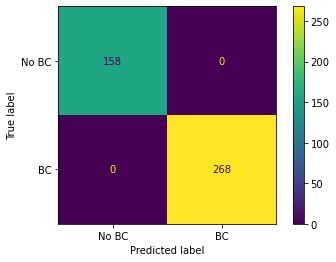

In [8]:
# Then visually compare it to y_test data using this confusion matrix

plot_confusion_matrix(clf_dt, X_train, y_train, display_labels=["No BC", "BC"])


# What is the accuracy of the model when it predicts the training Data

print('There was actually ' + str(y_train.sum()) + ' +ve BC Observations')
print('There was actually ' + str(len(y_train)-y_train.sum()) + ' -ve BC Observations')

There was actually 89  +ve BC Observations
There was actually 54 -ve BC Observations

 The accuracy score when predicting the test data 0.9370629370629371



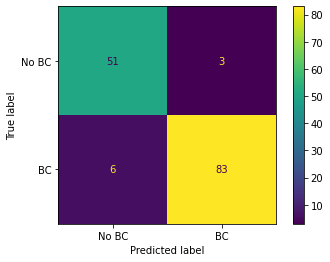

In [9]:
# Predict the TESTING data it should be less than 100%

# We trained the model using X_train and y_train

# We now predict "y_test" from "X_test" using the clf_dt model

# predict the test daya y_test
y_test_pred = clf_dt.predict(X_test)

# Then compare it to y_test data using this confusion matrix
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels=["No BC", "BC"])

# What is the accuracy of the model when it predicts the test Data (should be lower)  
print('There was actually ' + str(y_test.sum()) + '  +ve BC Observations')
print('There was actually ' + str(len(y_test)-y_test.sum()) + ' -ve BC Observations')
print ('')
print(f' The accuracy score when predicting the test data {accuracy_score(y_test_pred,y_test)}')
print ('')

In [10]:
def f1_score(clf_dt, X_test, y_test):
    y_test_pred = clf_dt.predict(X_test)
    CM = metrics.confusion_matrix(y_true = y_test, y_pred = y_test_pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    PPV = TP/(TP+FP)
    TPR = TP/(TP+FN)
    F1 = 2 * ((PPV*TPR)/(PPV+TPR))
    return F1

f1_score(clf_dt, X_test, y_test)

0.9485714285714285

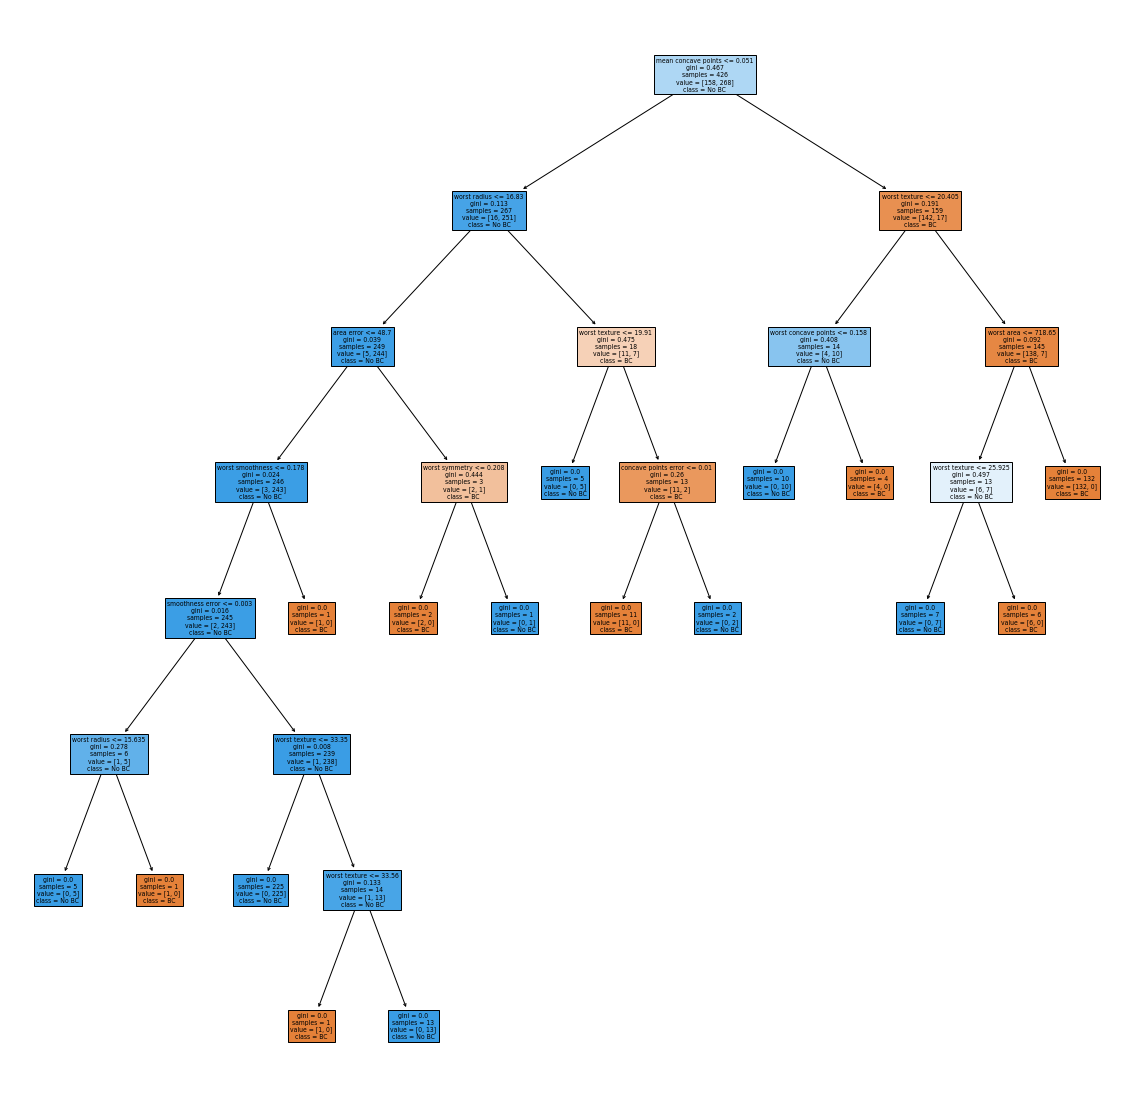

In [11]:
# Now we will viualise the decision tree where I think all terminal leaf nodes should be pure.

from sklearn import tree
plt.figure(figsize=(20,20))
features = df.columns
classes = ['BC','No BC'] # How to know the order.
tree.plot_tree(clf_dt,feature_names=features,class_names=classes,filled=True)
plt.show()

# Part one: Making an initial model ------ END

# Part two i: Optimization of model finding the best parameter alpha.

# Done via first optmizing for accuracy
# Then for F1 score (where multiple top accuracies are found

# --------------------- Finding the possible alphas : start ----------------

In [12]:
# Determine the possible alphas and corresponding impurity in the leaf nodes

path = clf_dt.cost_complexity_pruning_path(X_train, y_train)

Text(0, 0.5, 'total impurity of terminal leaf nodes')

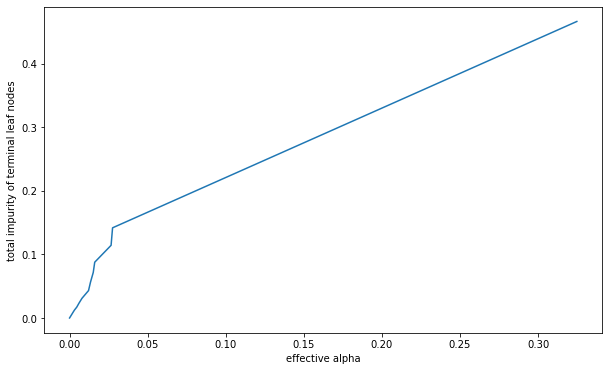

In [13]:
# We can visualise this

ccp_alphas, impurities = path.ccp_alphas, path.impurities
plt.figure(figsize=(10,6))
plt.plot(ccp_alphas,impurities)
plt.xlabel("effective alpha")
plt.ylabel("total impurity of terminal leaf nodes")

In [14]:
#Extract the alphas -returns in array format
ccp_alphas = path.ccp_alphas

In [15]:
#Remove the last alpha -(which is just the root)
ccp_alphas = ccp_alphas[:-1]

# --------------------- Finding the possible alphas : End ----------------

# Using accuracy as a quality metric ----- START

In [16]:
# We do this by making a decision tree for every alpha

# List of decision trees - There will be one for every possible alpha
clf_dts = []

In [17]:
# We run a loop for all of the alphas and put all of the DT into an array

# We make a list of DT for every alpha
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
    clf_dt.fit(X_train,y_train)
    clf_dts.append(clf_dt)
    pass


In [18]:
# We find the accuracy for every DT on the training data and test data for each
# of the new alpha decision trees

train_scores =  [         clf_dt.score(X_train, y_train)    for clf_dt      in clf_dts       ]
test_scores =  [         clf_dt.score(X_test, y_test)    for clf_dt      in clf_dts       ]

alpha_df = pd.DataFrame(ccp_alphas, columns = ["Alphas"])
train_scores_df = pd.DataFrame(train_scores, columns = ["Train Score"])
test_scores_df = pd.DataFrame(test_scores, columns = ["Test Score"])


alpha_frame = alpha_df.join( [train_scores_df , test_scores_df] )
alpha_frame

,Alphas,Train Score,Test Score
0,0.000000,1.000000,0.930070
1,0.002328,0.995305,0.944056
2,0.003130,0.992958,0.944056
3,0.004600,0.990610,0.951049
4,0.005960,0.988263,0.958042
5,0.007945,0.983568,0.958042
6,0.012138,0.971831,0.951049
7,0.013414,0.962441,0.930070
8,0.015168,0.948357,0.930070
9,0.016109,0.946009,0.916084


<function matplotlib.pyplot.show(close=None, block=None)>

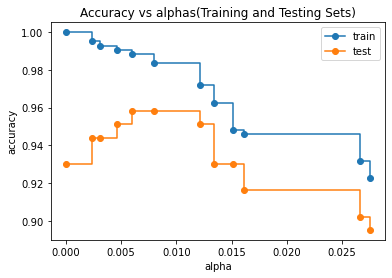

In [19]:
# Plotting the above
ax = plt.subplot()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alphas(Training and Testing Sets)")
ax.plot(ccp_alphas, train_scores, marker = 'o' , label = "train" , drawstyle = "steps-post")
ax.plot(ccp_alphas, test_scores, marker = 'o' , label = "test" , drawstyle = "steps-post")

ax.legend()
plt.show

In [20]:
# From inspection above you can see that the accuracy of the model
# looks best where the test line peaks
# This may not be the optimal value
# We use cross validation and different folds to work out what the best alpha is

# Using a different number of folds - is splitting the data into training and testing in different ways

# CROSS VALIDATION TO FIND THE BEST ALPHA

# An array to store the results of each fold
alpha_loop_values = []


# We then run a loop for all of the alphas with a 5 fold cross validation

for ccp_alpha in ccp_alphas:
    
    clf_dt = DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
    clf_dt.fit(X_train,y_train)
    
    # Produce a set of accuracy scores for 5 folds
    scores = cross_val_score(clf_dt, X_train, y_train, cv = 5)
    
    # Add to the array the an alpha column mean cross_val_score
    alpha_loop_values.append([  ccp_alpha  ,  np.mean(scores)  ,  np.std(scores) ])
    
    pass


In [21]:
alpha_results = pd.DataFrame(alpha_loop_values, columns = ['alpha', 'mean_accuracy' ,  'std' ])
alpha_results

,alpha,mean_accuracy,std
0,0.000000,0.920164,0.011665
1,0.002328,0.920164,0.011665
2,0.003130,0.922490,0.014301
3,0.004600,0.917784,0.021200
4,0.005960,0.915458,0.018949
5,0.007945,0.920164,0.011665
6,0.012138,0.927168,0.018975
7,0.013414,0.927168,0.018975
8,0.015168,0.927168,0.018975
9,0.016109,0.915486,0.013758


<AxesSubplot:xlabel='alpha'>

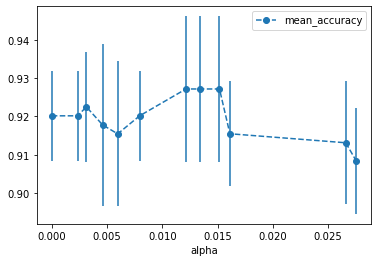

In [22]:
alpha_results.plot(x="alpha",y='mean_accuracy', yerr = 'std' , marker ='o', ls = '--')

In [23]:
alpha_results

,alpha,mean_accuracy,std
0,0.000000,0.920164,0.011665
1,0.002328,0.920164,0.011665
2,0.003130,0.922490,0.014301
3,0.004600,0.917784,0.021200
4,0.005960,0.915458,0.018949
5,0.007945,0.920164,0.011665
6,0.012138,0.927168,0.018975
7,0.013414,0.927168,0.018975
8,0.015168,0.927168,0.018975
9,0.016109,0.915486,0.013758


In [24]:

###########################################################################
# Find the highest accuracy ALPHA
a = alpha_results.loc[alpha_results['mean_accuracy'] == alpha_results['mean_accuracy'].max(),'alpha']


best_alphas = alpha_results[alpha_results['mean_accuracy'] == alpha_results['mean_accuracy'].max()].copy()

best_alphas

,alpha,mean_accuracy,std
6,0.012138,0.927168,0.018975
7,0.013414,0.927168,0.018975
8,0.015168,0.927168,0.018975


# Using accuracy a a quality metric ----- END


# Iterate through the best alphas to find the one with the lowest f1 score. (Additional, likely not needed with real data)---START

In [25]:
from sklearn import metrics
f1s = []

for alpha in best_alphas['alpha']:
    clf_dt = DecisionTreeClassifier(random_state = 0, ccp_alpha = alpha)
    clf_dt.fit(X_train,y_train)
    
    y_test_pred = clf_dt.predict(X_test)
    
    CM = metrics.confusion_matrix(y_true = y_test, y_pred = y_test_pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    PPV = TP/(TP+FP)
    TPR = TP/(TP+FN)
    F1 = 2 * ((PPV*TPR)/(PPV+TPR))
    
    f1s.append(F1)
    pass


In [26]:
best_alphas['F1s'] = f1s

best_alphas

,alpha,mean_accuracy,std,F1s
6,0.012138,0.927168,0.018975,0.960452
7,0.013414,0.927168,0.018975,0.944444
8,0.015168,0.927168,0.018975,0.945055


In [27]:
ideal_ccp_alpha = best_alphas[best_alphas['F1s'] == best_alphas['F1s'].max()]['alpha'].max()

###########################################################################

# I think this will return an error on randint generated data sets with
# there being so little difference in mean accuracy between alphas


# THESE MAY NEED TO BE INDIVIDUALLY STUDIED

ideal_ccp_alpha

###########################################################################

0.012138357208779744

In [28]:
###########################################################################
# REPLOT WITH THE ACCURATE ALPHA
clf_dt_pruned = DecisionTreeClassifier(random_state=4, ccp_alpha = ideal_ccp_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

###########################################################################

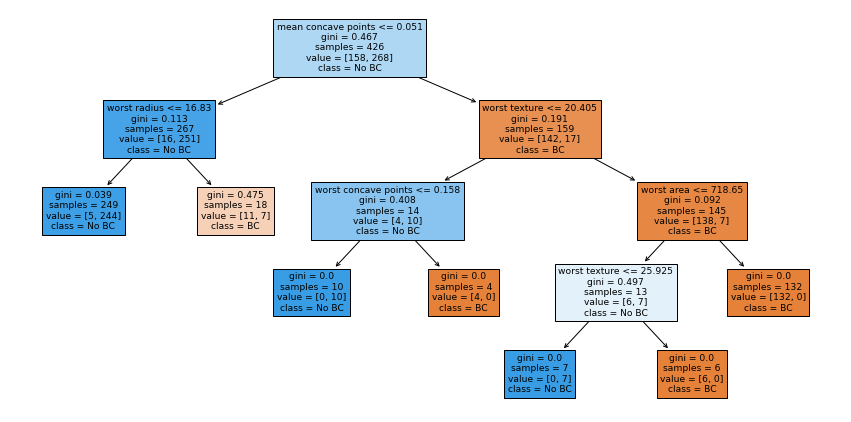

In [29]:
# Plot
# The Tree
plt.figure(figsize=(15,7.5))
tree.plot_tree(clf_dt_pruned,feature_names=features,class_names=classes,filled=True)
plt.show()


 The accuracy score when predicting the training data (should be high) here it is 0.971830985915493

There was actually 268 +ve BC Observations
There was actually 158 -ve BC Observations


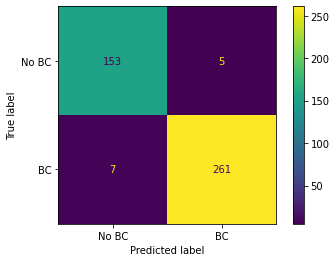

In [30]:
# Predict the training data it should be 100%  
# - Not really need but provides a sanity test and could show if any mistakes have crept up

# We trained the model using X_train and y_train

# Then compare it to y_test data using this confusion matrix

plot_confusion_matrix(clf_dt_pruned, X_train, y_train, display_labels=["No BC", "BC"])

# predict the training data y_train
y_train_pred = clf_dt_pruned.predict(X_train)

# What is the accuracy of the model when it predicts the ___ Training Data
print ('')
print(f' The accuracy score when predicting the training data (should be high) here it is {accuracy_score(  y_train_pred ,  y_train)}')
print ('')
print('There was actually ' + str(y_train.sum()) + ' +ve BC Observations')
print('There was actually ' + str(len(y_train)-y_train.sum()) + ' -ve BC Observations')


 The accuracy score when predicting the test data (should be lower)  0.9440559440559441



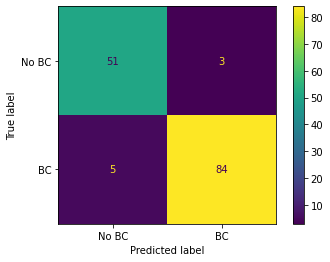

In [31]:
# Predict the TESTING data it should be less than 100%

# We trained the model using X_train and y_train

# We now predict y from "X_test" using the clf_dt model

# predict the test daya y_test
y_test_pred = clf_dt_pruned.predict(X_test)

# Then compare it to y_test data using this confusion matrix
plot_confusion_matrix(clf_dt_pruned, X_test, y_test, display_labels=["No BC", "BC"])



# What is the accuracy of the model when it predicts the ___ Test Data
print ('')
print(f' The accuracy score when predicting the test data (should be lower)  {accuracy_score(y_test_pred,y_test)}')
print ('')

The f1-score for this model is:

In [32]:
def f1_score(clf_dt, X_test, y_test):
    y_test_pred = clf_dt.predict(X_test)
    CM = metrics.confusion_matrix(y_true = y_test, y_pred = y_test_pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    PPV = TP/(TP+FP)
    TPR = TP/(TP+FN)
    F1 = 2 * ((PPV*TPR)/(PPV+TPR))
    return F1

f1_score(clf_dt_pruned, X_test, y_test)

0.9545454545454545

In [33]:
ideal_ccp_alpha

0.012138357208779744

# Iterate through the best alphas to find the one with the lowest f1 score. (Additional, likely not needed with real data)---END

The best alpha has now been found

The above tree is now optimized.

# THOUGHT

# It may be better to optimize for f1 alone and not accuracy at all during the pruning stage given data input may have an unequal amount of postive and negative labels

In [34]:
# Step 7 - Get predictions = your final results

In [35]:
# After collecting data an extra column will need to be added
# it will be a show of that are about to flood based on previous flood.
# {No flood, about to flood, flooded}

# Finding best alpha with just f1 score

In [36]:
# We do this by making a decision tree for every alpha
ccp_alphas

array([0.        , 0.00232826, 0.00312989, 0.00459972, 0.00596017,
       0.00794511, 0.01213836, 0.01341382, 0.01516793, 0.01610939,
       0.02658769, 0.02752968])

<function matplotlib.pyplot.show(close=None, block=None)>

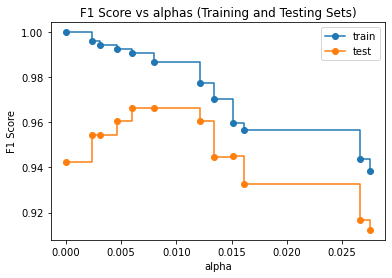

In [37]:
# List of decision trees - There will be one for every possible alpha
clf_dts = []

# We run a loop for all of the alphas and put all of the DT into an array

# We make a list of DT for every alpha
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
    clf_dt.fit(X_train,y_train)
    clf_dts.append(clf_dt)
    pass


# We find the F1 SCORE for every DT on the training data and test data for each
# of the new alpha decision trees

def f1_score(clf_dt, X_test, y_test):
    y_test_pred = clf_dt.predict(X_test)
    CM = metrics.confusion_matrix(y_true = y_test, y_pred = y_test_pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    PPV = TP/(TP+FP)
    TPR = TP/(TP+FN)
    F1 = 2 * ((PPV*TPR)/(PPV+TPR))
    return F1


train_scores =  [f1_score(clf_dt, X_train, y_train)    for clf_dt      in clf_dts       ]
test_scores =  [f1_score(clf_dt, X_test, y_test)    for clf_dt      in clf_dts       ]

alpha_df = pd.DataFrame(ccp_alphas, columns = ["Alphas"])
train_scores_df = pd.DataFrame(train_scores, columns = ["Train F1 Score"])
test_scores_df = pd.DataFrame(test_scores, columns = ["Test F1 Score"])

alpha_frame = alpha_df.join( [train_scores_df , test_scores_df] )
alpha_frame

# Plotting the above
ax = plt.subplot()
ax.set_xlabel("alpha")
ax.set_ylabel("F1 Score")
ax.set_title("F1 Score vs alphas (Training and Testing Sets)")
ax.plot(ccp_alphas, train_scores, marker = 'o' , label = "train" , drawstyle = "steps-post")
ax.plot(ccp_alphas, test_scores, marker = 'o' , label = "test" , drawstyle = "steps-post")
ax.legend()
plt.show


<AxesSubplot:xlabel='tree'>

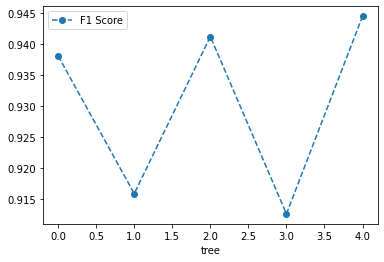

In [38]:
# From inspection above you can see that the accuracy of the model
# looks best where the test line peaks
# This may not be the optimal value
# We use cross validation and different folds to work out what the best alpha is

# With 5-fold cross validation we create 5 different training and testing datasets
# that are used to train and test the tree


# Example explanation:
# Below returns a list of 5 scores for a decision tree for the tenth alpha
clf_dt = DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alphas[10])

scores = cross_val_score(clf_dt, X_train, y_train, scoring="f1" , cv = 5)
df = pd.DataFrame(data = {'tree': range(5), 'F1 Score': scores})
df.plot(x = 'tree', y= 'F1 Score', marker = 'o', ls ='--')

In [39]:
# From inspection above you can see that the F1 score of the model
# varies for the same alpha depending on how the data is split


# We use cross validation and different folds to work out what the best alpha is
# by averaging the f1 score for each 5 of the folds per alpha


# CROSS VALIDATION TO FIND THE BEST ALPHA

# An array to store the results of each fold
alpha_loop_values = []


def range_of_vals(x, axis=0):
    return np.max(x, axis=axis) - np.min(x, axis=axis)

# We then run a loop for all of the alphas with a 5 fold cross validation

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
    clf_dt.fit(X_train,y_train)
    
    # Produce a set of F1-Score scores for 5 folds
    scores = cross_val_score(clf_dt, X_train, y_train, scoring="f1" , cv = 5)
    # Add to the array the an alpha column mean cross_val_score
    alpha_loop_values.append([  ccp_alpha  ,  np.mean(scores)  ,  np.std(scores), range_of_vals(scores) ])
    pass



alpha_results = pd.DataFrame(alpha_loop_values, columns = ['alpha', 'mean_f1_score' ,  'std', 'range' ])
alpha_results



,alpha,mean_f1_score,std,range
0,0.000000,0.936602,0.008775,0.019529
1,0.002328,0.936602,0.008775,0.019529
2,0.003130,0.938502,0.011184,0.029029
3,0.004600,0.934449,0.017110,0.049295
4,0.005960,0.932464,0.015446,0.040768
5,0.007945,0.936517,0.009327,0.021900
6,0.012138,0.941935,0.015218,0.047749
7,0.013414,0.941708,0.015219,0.047749
8,0.015168,0.941708,0.015219,0.047749
9,0.016109,0.933098,0.010641,0.028557


<AxesSubplot:xlabel='alpha'>

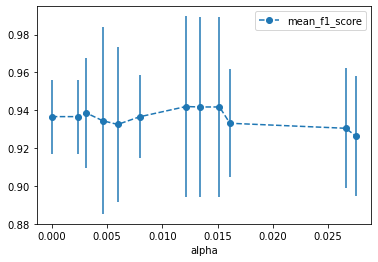

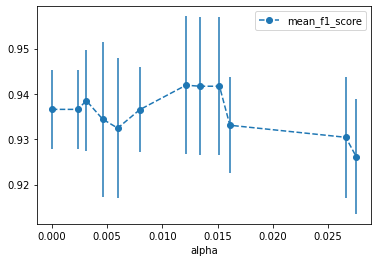

In [40]:
alpha_results.plot(x="alpha",y='mean_f1_score', yerr = 'range' , marker ='o', ls = '--')
alpha_results.plot(x="alpha",y='mean_f1_score', yerr = 'std' , marker ='o', ls = '--')


In [41]:
# Even though the above mean f1 scores can have considerable std and range...
# ... Note that they may be insignicant when it comes to real data sets.
# ... It is likely that the best model will be that with the highest average f1-score

###########################################################################
# Find the highest mean F1 scoring ALPHA
a = alpha_results.loc[alpha_results['mean_f1_score'] == alpha_results['mean_f1_score'].max(),'alpha']


best_alphas = alpha_results[alpha_results['mean_f1_score'] == alpha_results['mean_f1_score'].max()].copy()

best_alphas

,alpha,mean_f1_score,std,range
6,0.012138,0.941935,0.015218,0.047749


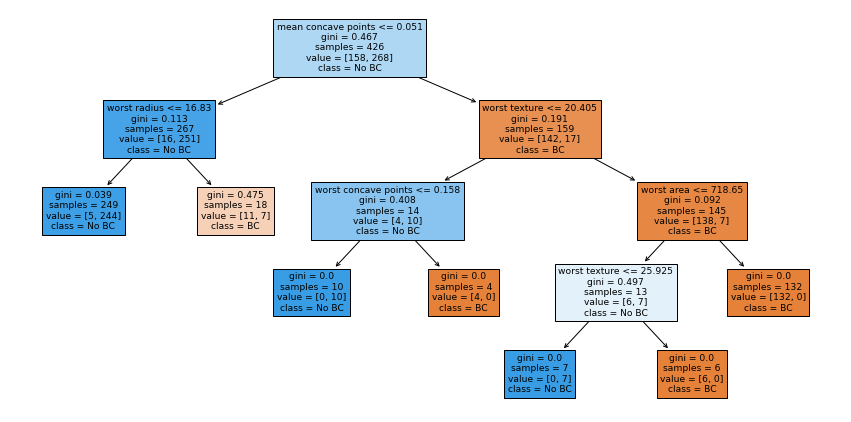

In [42]:
ideal_ccp_alpha = best_alphas[best_alphas['mean_f1_score'] == best_alphas['mean_f1_score'].max()]['alpha'].max()

###########################################################################
# REPLOT WITH THE ACCURATE ALPHA
clf_dt_pruned = DecisionTreeClassifier(random_state=4, ccp_alpha = ideal_ccp_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

###########################################################################

# Plot
# The Tree
plt.figure(figsize=(15,7.5))
tree.plot_tree(clf_dt_pruned,feature_names=features,class_names=classes,filled=True)
plt.show()


 The accuracy score when predicting the training data (should be high) here it is 0.971830985915493

There was actually 268 +ve BC Observations
There was actually 158 -ve BC Observations

 The accuracy score when predicting the test data (should be lower)  0.9440559440559441



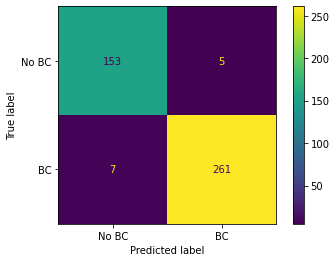

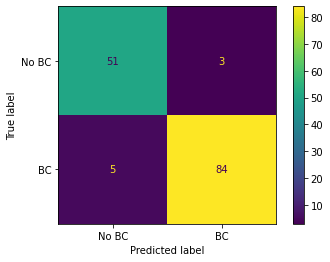

In [43]:
# Predict the training data it should be 100%  
# - Not really need but provides a sanity test and could show if any mistakes have crept up

# We trained the model using X_train and y_train


# Then compare it to y_test data using this confusion matrix

plot_confusion_matrix(clf_dt_pruned, X_train, y_train, display_labels=["No BC", "BC"])

# predict the training data y_train
y_train_pred = clf_dt_pruned.predict(X_train)

# What is the accuracy of the model when it predicts the ___ Training Data
print ('')
print(f' The accuracy score when predicting the training data (should be high) here it is {accuracy_score(  y_train_pred ,  y_train)}')
print ('')
print('There was actually ' + str(y_train.sum()) + ' +ve BC Observations')
print('There was actually ' + str(len(y_train)-y_train.sum()) + ' -ve BC Observations')

# Predict the TESTING data it should be less than 100%

# We trained the model using X_train and y_train

# We now predict y from "X_test" using the clf_dt model

# predict the test daya y_test
y_test_pred = clf_dt_pruned.predict(X_test)

# Then compare it to y_test data using this confusion matrix
plot_confusion_matrix(clf_dt_pruned, X_test, y_test, display_labels=["No BC", "BC"])



# What is the accuracy of the model when it predicts the ___ Test Data
print ('')
print(f' The accuracy score when predicting the test data (should be lower)  {accuracy_score(y_test_pred,y_test)}')
print ('')

In [44]:
f1_score(clf_dt_pruned, X_test, y_test)

0.9545454545454545

In [45]:
ideal_ccp_alpha

0.012138357208779744

In [46]:
# note this final result of the error metrics here is lower than that of the original initial iteration.

# One might presume that the orginal split was an overfit fluke.
# The final f1_score may be lower but it will generalise better to new unseen data